In [8]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Ignorar warnings
warnings.filterwarnings("ignore")

# Define os nomes das colunas e as larguras de cada campo
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

# Carrega o arquivo
df_1 = pd.read_fwf('../../DB/COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2 = pd.read_fwf('../../DB/COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df_3 = pd.read_fwf('../../DB/COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)
# Filtra pela ação VALE3, garantindo que seja exatamente VALE3 (sem caracteres adicionais)
mxrf11_df1 = df_1[df_1['Codigo'].str.endswith('MXRF11')]
mxrf11_df2 = df_2[df_2['Codigo'].str.endswith('MXRF11')]
mxrf11_df3 = df_3[df_3['Codigo'].str.endswith('MXRF11')]

In [18]:
def plot_df(df,tendencia,sazonalidade,ruido,title,column):
    # Plot dos componentes de decomposição
    plt.figure(figsize=(12, 8))
    plt.plot(df.index, df[column], label='Série Original')
    plt.plot(df.index, tendencia, label='Tendência', linestyle='--')
    plt.plot(df.index, sazonalidade, label='Sazonalidade', linestyle='--')
    plt.plot(df.index, ruido, label='Ruído', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.title(title)
    plt.legend()
    plt.show()

Empty DataFrame
Columns: [Data, Codigo, Preco_Abertura, Preco_Fechamento, Ano, Mes, Dia, Suavizacao, Z-score]
Index: []


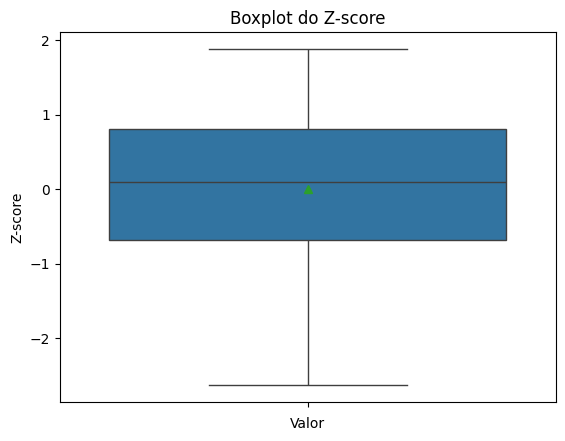

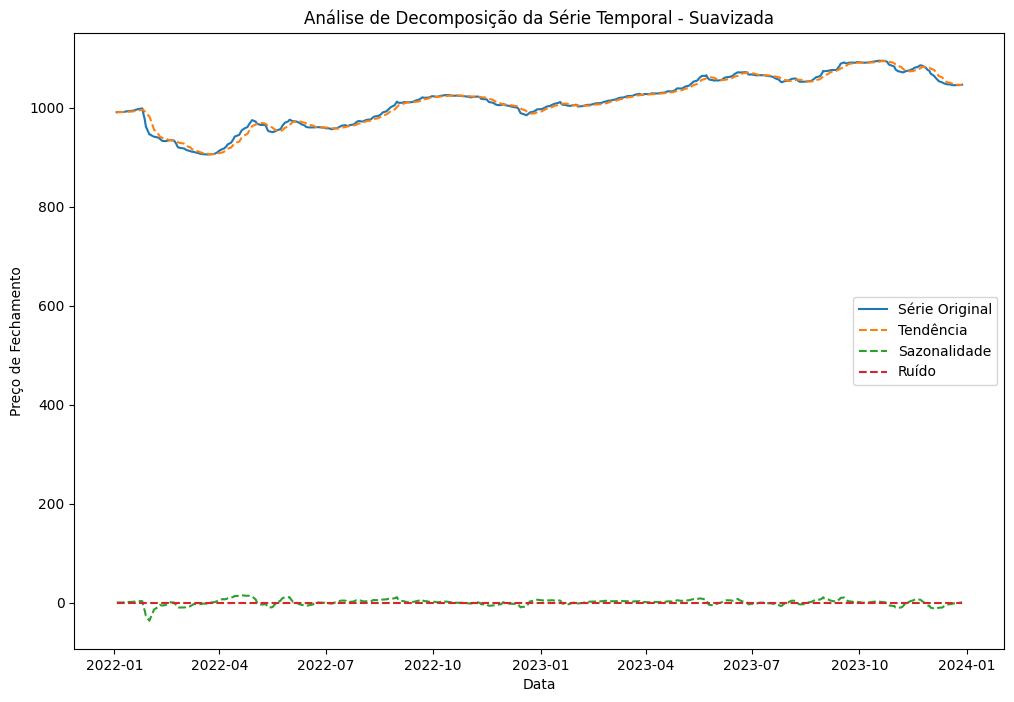

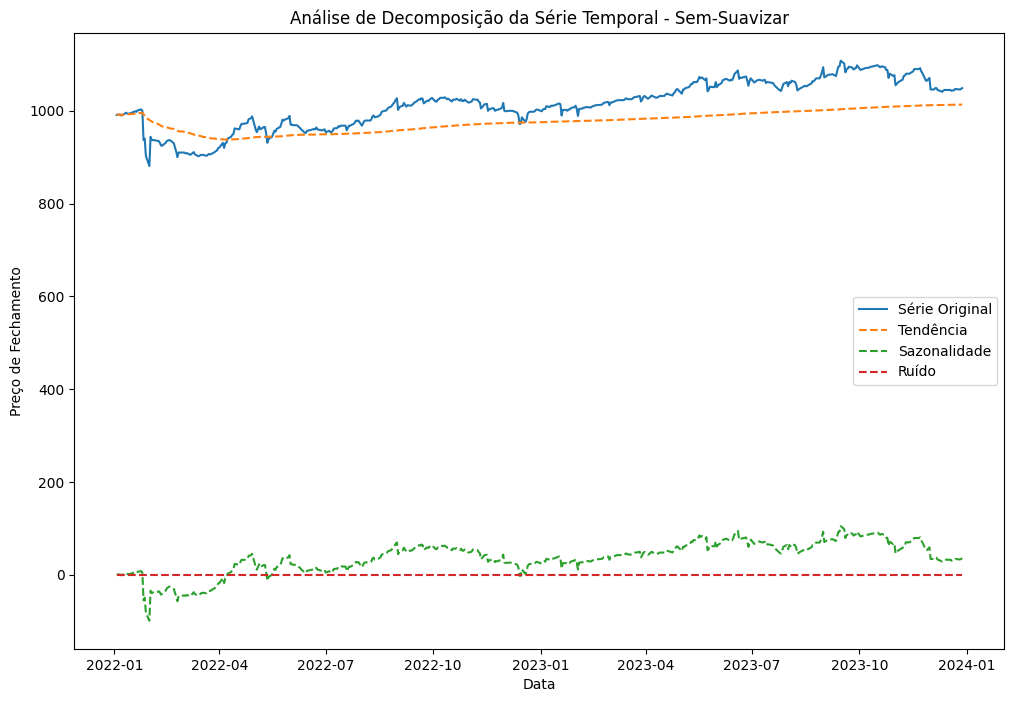

Empty DataFrame
Columns: [Data, Codigo, Preco_Abertura, Preco_Fechamento, Ano, Mes, Dia, Suavizacao, Z-score]
Index: []


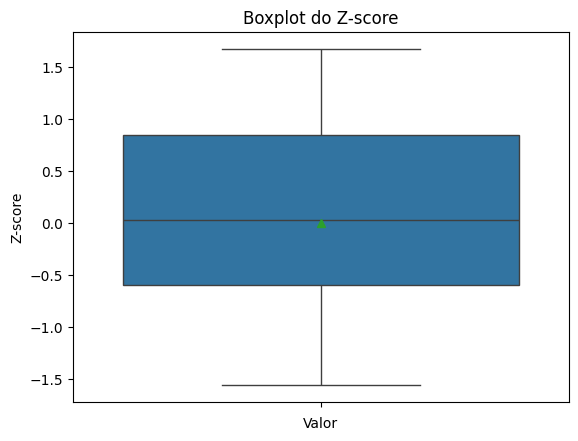

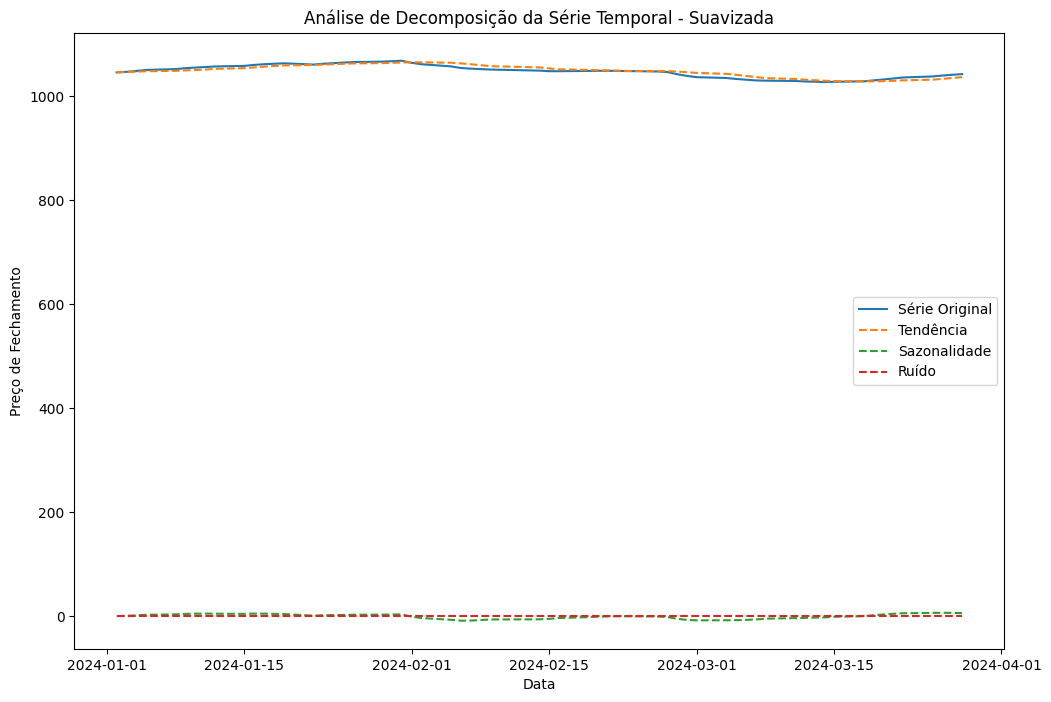

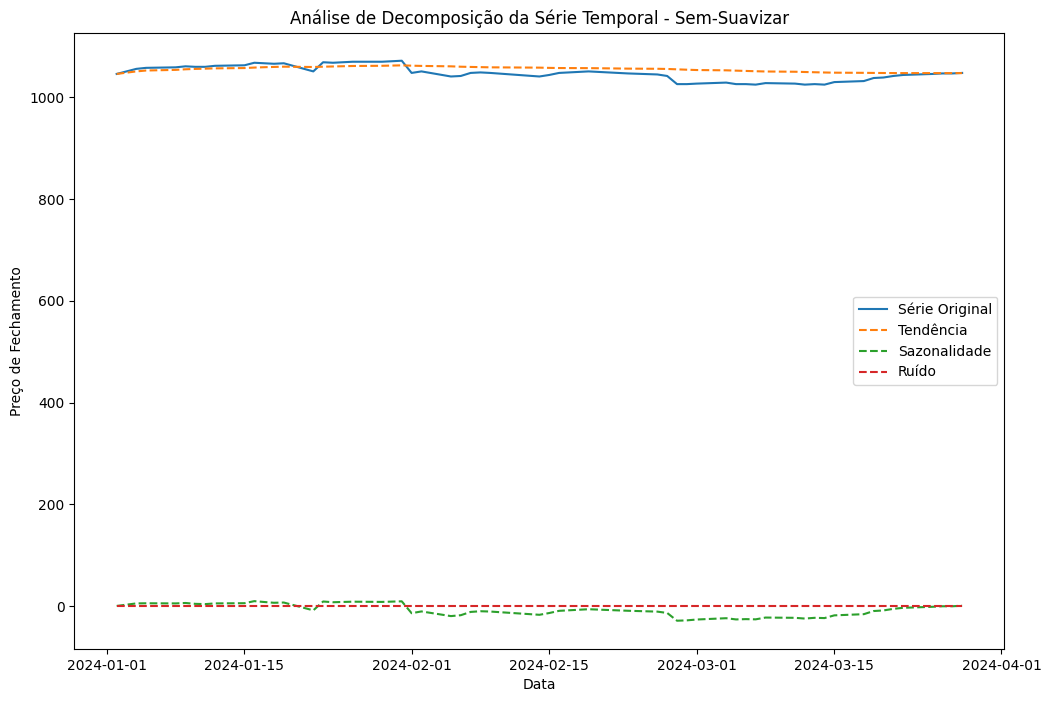

,Data,Codigo,Preco_Abertura,Preco_Fechamento,Ano,Mes,Dia,Suavizacao,Z-score
Data,,,,,,,,,
2024-01-02,2024-01-02,12MXRF11,1051.0,1046.0,2024,1,2,1046.000,-0.111701
2024-01-03,2024-01-03,12MXRF11,1051.0,1051.0,2024,1,3,1047.000,0.232428
2024-01-04,2024-01-04,12MXRF11,1058.0,1056.0,2024,1,4,1048.800,0.576556
2024-01-05,2024-01-05,12MXRF11,1058.0,1058.0,2024,1,5,1050.640,0.714207
2024-01-08,2024-01-08,12MXRF11,1059.0,1059.0,2024,1,8,1052.312,0.783033


In [25]:
import seaborn as sns
def preprocessamento_df(df):
    # Formatando as datas
    df['Data'] = pd.to_datetime(df['Data'], format='%Y%m%d')

    # Extraindo ano, mês e dia
    df['Ano'] = df['Data'].dt.year
    df['Mes'] = df['Data'].dt.month
    df['Dia'] = df['Data'].dt.day
    
    # Ordenar o DataFrame pela data
    df = df.sort_values(by='Data')
    df.set_index(df['Data'], inplace=True)

    
    # Suavização
    df['Suavizacao'] = df['Preco_Fechamento'].ewm(alpha=0.2, adjust=False).mean()
    
    # Componentes de Decomposição Sem-Suavizar
    tendencia = df['Preco_Fechamento'].rolling(window=len(df['Preco_Fechamento']), min_periods=1).mean()
    sazonalidade = df['Preco_Fechamento'] - tendencia
    ruido = df['Preco_Fechamento'] - (tendencia + sazonalidade)

    # Componentes de Decomposição Suavizado
    linhas = df.shape[1]
    tendencia_suavizada = df['Suavizacao'].rolling(window=linhas, min_periods=1).mean()
    sazonalidade_suavizada = df['Suavizacao'] - tendencia_suavizada
    ruido_suavizado = df['Suavizacao'] - (tendencia_suavizada + sazonalidade_suavizada)

    # Calcular a média e o desvio padrão
    mean_price = df['Preco_Fechamento'].mean()
    std_price = df['Preco_Fechamento'].std()

    # Calcular o Z-score
    df['Z-score'] = (df['Preco_Fechamento'] - mean_price) / std_price

    #Outliers
    threshold = 2
    outliers = df[df['Z-score'] > threshold]
    print(outliers)
    sns.boxplot(
        y = "Z-score",
        showmeans=True,  # Exibe a média como um diamante no gráfico
        data=df
    )

    # Adicione título e eixos rotulados (opcional)
    plt.title("Boxplot do Z-score")
    plt.ylabel("Z-score")
    plt.xlabel("Valor")

    # Exiba o gráfico
    plt.show()

    #Plots Sem
    plot_df(df,tendencia_suavizada,sazonalidade_suavizada,ruido_suavizado,'Análise de Decomposição da Série Temporal - Suavizada','Suavizacao')
    plot_df(df,tendencia,sazonalidade,ruido,'Análise de Decomposição da Série Temporal - Sem-Suavizar','Preco_Fechamento')

    return df

# Aplicando a função preprocessamento_df nos DataFrames mxrf11_df1 e mxrf11_df2
df_treino = preprocessamento_df(pd.concat([mxrf11_df1, mxrf11_df2]))
df_teste = preprocessamento_df(mxrf11_df3)

In [37]:
# Concatenando os dataframes

def modelo(colunm):
    df_total = pd.concat([df_treino, df_teste])

    # Definindo o ponto de divisão
    ponto_divisao = len(df_treino)

    # Criando o novo dataframe de treino e teste
    novo_df_treino = df_total[:ponto_divisao]
    novo_df_teste = df_total[ponto_divisao:]

    # Treinando o modelo com o novo dataframe de treino
    modelo = ARIMA(novo_df_treino[colunm], order=(5,1,0))
    modelo_treinado = modelo.fit()

    # Fazendo a previsão com o novo dataframe de teste
    previsao = modelo_treinado.predict(start=len(novo_df_treino), end=len(novo_df_treino) + len(novo_df_teste) - 1, typ='levels')
    previsao.index = novo_df_teste.index
    novo_df_teste['Previsao'] = previsao
    # Avaliação da Acurácia
    mse = mean_squared_error(novo_df_teste[colunm], previsao)
    rmse = np.sqrt(mse)
    print("Raiz do Erro Quadrático Médio (RMSE):", rmse)
    novo_df_teste.head(20)
    describe = df_total[colunm].describe()
    print(describe)

    metade_std = df_total[colunm].std() / 2
    um_terco_std = df_total[colunm].std() / 3
    # Comparando o RMSE com o desvio padrão, a metade e um terço do desvio padrão
    if rmse > df_total[colunm].std():
        print("Modelo ruim")
    elif rmse > metade_std:
        print("Modelo ruim")
    elif rmse <= metade_std and rmse > um_terco_std:
        print("Modelo médio")
    else:
        print("Modelo bom")

modelo('Preco_Fechamento')
modelo('Suavizacao')

Raiz do Erro Quadrático Médio (RMSE): 14.421563874397341
count     559.000000
mean     1017.078712
std        48.919078
min       881.000000
25%       988.000000
50%      1024.000000
75%      1055.000000
max      1108.000000
Name: Preco_Fechamento, dtype: float64
Modelo bom
Raiz do Erro Quadrático Médio (RMSE): 12.252342139169553
count     559.000000
mean     1016.704693
std        48.046565
min       905.423794
25%       985.315164
50%      1022.303427
75%      1056.046989
max      1095.028620
Name: Suavizacao, dtype: float64
Modelo bom
